# **1. Data Loading**

In [ ]:
import pandas as pd
data = pd.read_csv("NLP_Dataset_Extended.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

data.rename(columns={'Input': 'Health_Record', 'Prediction': 'Risk_Level'}, inplace=True)

print("\n✅ Dataset Overview:")
print(data.info())

print("\n✅ Sample Data:")
print(data.head())




✅ Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Health_Record  2000 non-null   object
 1   Risk_Level     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None

✅ Sample Data:
                                       Health_Record Risk_Level
0  Patient is a 62-year-old female with total cho...   low-risk
1  Patient is a 52-year-old male with total chole...  high-risk
2  Patient is a 32-year-old male with total chole...  high-risk
3  Patient is a 40-year-old female with total cho...  high-risk
4  Patient is a 66-year-old female with total cho...  high-risk


<ipython-input-3-988db4b0204e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk_Level', data=data, palette='coolwarm')


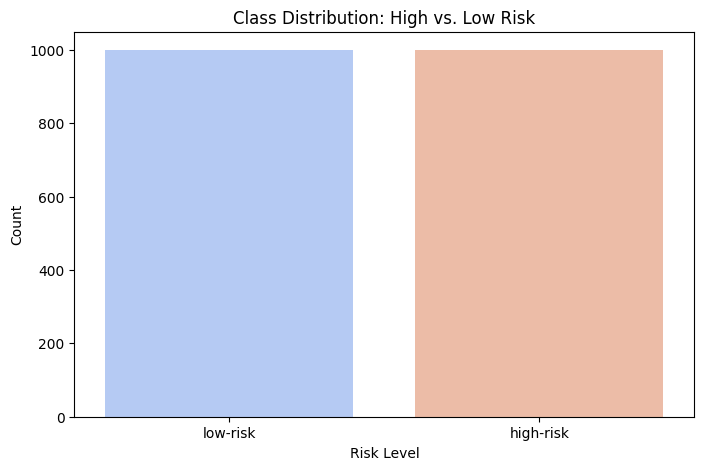


✅ Text Length Statistics:
count    2000.000000
mean       34.095500
std         2.769154
min        31.000000
25%        32.000000
50%        33.000000
75%        37.000000
max        42.000000
Name: text_length, dtype: float64


In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Risk_Level', data=data, palette='coolwarm')
plt.title('Class Distribution: High vs. Low Risk')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

data['text_length'] = data['Health_Record'].apply(lambda x: len(x.split()))
print("\n✅ Text Length Statistics:")
print(data['text_length'].describe())




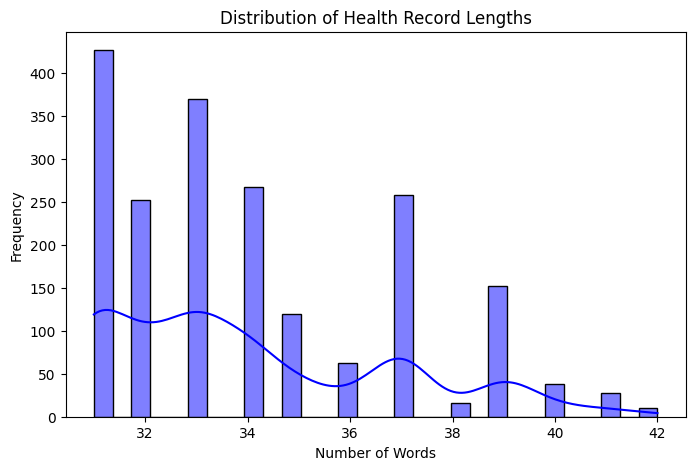


✅ Dataset Split Summary:
Training Data: 1440 samples
Validation Data: 160 samples
Test Data: 400 samples


In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Health Record Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Splitting Data into Train, Validation, and Test Sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Risk_Level'])
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, stratify=train_data['Risk_Level'])

# Show dataset sizes
print("\n✅ Dataset Split Summary:")
print(f"Training Data: {train_data.shape[0]} samples")
print(f"Validation Data: {val_data.shape[0]} samples")
print(f"Test Data: {test_data.shape[0]} samples")

# **2. Text Processing**

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    important_terms = {"diabetes", "cholesterol", "blood", "pressure", "heart", "disease", "smoker"}
    tokens = [word for word in tokens if word not in stop_words or word in important_terms]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

train_data['processed_text'] = train_data['Health_Record'].apply(preprocess_text)
val_data['processed_text'] = val_data['Health_Record'].apply(preprocess_text)
test_data['processed_text'] = test_data['Health_Record'].apply(preprocess_text)

print(train_data[['Health_Record', 'processed_text']].head())

                                          Health_Record  \
269   "Patient is a 43-year-old female with total ch...   
73    "Patient is a 24-year-old female with total ch...   
481   "Patient is a 72-year-old female with total ch...   
1370  "Patient is a 44-year-old male with total chol...   
150   "Patient is a 31-year-old female with total ch...   

                                         processed_text  
269   patient 43 year old female total cholesterol 2...  
73    patient 24 year old female total cholesterol 2...  
481   patient 72 year old female total cholesterol 1...  
1370  patient 44 year old male total cholesterol 258...  
150   patient 31 year old female total cholesterol 2...  


# **3. Text Embedding**

In [ ]:
!pip install fasttext
import fasttext
import fasttext.util
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [ ]:
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

def get_sentence_embeddings(text, model):
    return model.encode(text, show_progress_bar=False)

X_train_embeddings = np.array([get_sentence_embeddings(text, model) for text in train_data['processed_text']])
X_val_embeddings = np.array([get_sentence_embeddings(text, model) for text in val_data['processed_text']])
X_test_embeddings = np.array([get_sentence_embeddings(text, model) for text in test_data['processed_text']])

print("Feature extraction completed using SentenceTransformer embeddings.")

Feature extraction completed using SentenceTransformer embeddings.


# **4. Model Training with Different Architectures**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Flatten


In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['Risk_Level'])
y_val = label_encoder.transform(val_data['Risk_Level'])
y_test = label_encoder.transform(test_data['Risk_Level'])

X_train = X_train_embeddings.reshape((X_train_embeddings.shape[0], 1, X_train_embeddings.shape[1]))
X_val = X_val_embeddings.reshape((X_val_embeddings.shape[0], 1, X_val_embeddings.shape[1]))
X_test = X_test_embeddings.reshape((X_test_embeddings.shape[0], 1, X_test_embeddings.shape[1]))

def cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def cnn_bilstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (1, 384)  # Shape for SentenceTransformer embeddings (timesteps=1, features=384)

class_weights = {0: 1.0, 1: 308/92}  # ~3.35x weight for minority class

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cnn = cnn_model(input_shape)
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stopping])

lstm = lstm_model(input_shape)
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stopping])

cnn_bilstm = cnn_bilstm_model(input_shape)
cnn_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
cnn_bilstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64, class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7413 - loss: 1.0513 - weighted_accuracy: 0.5799 - val_accuracy: 0.4187 - val_loss: 0.6991 - val_weighted_accuracy: 0.4187
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4358 - loss: 1.0654 - weighted_accuracy: 0.6059 - val_accuracy: 0.7437 - val_loss: 0.6257 - val_weighted_accuracy: 0.7437
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7032 - loss: 0.9547 - weighted_accuracy: 0.6996 - val_accuracy: 0.7250 - val_loss: 0.5867 - val_weighted_accuracy: 0.7250
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7063 - loss: 0.8611 - weighted_accuracy: 0.7191 - val_accuracy: 0.7563 - val_loss: 0.5041 - val_weighted_accuracy: 0.7563
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7233 - loss: 0.8031 - weighted_accuracy: 0.7521 - val_accuracy: 0.7812 - val_loss: 0.4697 - val_weighted_accuracy: 0.7812
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7715 - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7572 - loss: 1.0515 - weighted_accuracy: 0.5655 - val_accuracy: 0.6187 - val_loss: 0.6860 - val_weighted_accuracy: 0.6187
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5257 - loss: 1.0389 - weighted_accuracy: 0.6525 - val_accuracy: 0.7312 - val_loss: 0.6534 - val_weighted_accuracy: 0.7312
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6785 - loss: 1.0198 - weighted_accuracy: 0.6989 - val_accuracy: 0.7812 - val_loss: 0.5966 - val_weighted_accuracy: 0.7812
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7073 - loss: 0.9617 - weighted_accuracy: 0.7212 - val_accuracy: 0.7875 - val_loss: 0.5388 - val_weighted_accuracy: 0.7875
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7009 - loss: 0.8870 - weighted_accuracy: 0.7087 - val_accuracy: 0.7375 - val_loss: 0.5484 - val_weighted_accuracy: 0.7375
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7584 - loss

# **5. Comparative analysis of model**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_cnn = cnn.predict(X_test)
y_pred_lstm = lstm.predict(X_test)
y_pred_cnn_bilstm = cnn_bilstm.predict(X_test)

cnn_acc = accuracy_score(y_test, y_pred_cnn.round())
print("CNN Accuracy:", cnn_acc)
print("CNN Classification Report:\n", classification_report(y_test, y_pred_cnn.round()))

lstm_acc = accuracy_score(y_test, y_pred_lstm.round())
print("LSTM Accuracy:", lstm_acc)
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm.round()))

cnn_bilstm_acc = accuracy_score(y_test, y_pred_cnn_bilstm.round())
print("CNN-BiLSTM Accuracy:", cnn_bilstm_acc)
print("CNN-BiLSTM Classification Report:\n", classification_report(y_test, y_pred_cnn_bilstm.round()))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
CNN Accuracy: 0.8075
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       308
           1       0.56      0.76      0.65        92

    accuracy                           0.81       400
   macro avg       0.74      0.79      0.76       400
weighted avg       0.84      0.81      0.82       400

LSTM Accuracy: 0.81
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       308
           1       0.57      0.71      0.63        92

    accuracy                           0.81       400
   macro avg       0.74      0.77      0.75       400
weighted avg       0.83      0.81      0.82       400

CNN-BiLSTM Accuracy: 0.8225
CNN-BiLSTM Classification Report:
               precision    recall  f1-score   support

         

# **6. Saving the Best Model**

In [ ]:
cnn_bilstm.save('best_text_classification_model.h5')
print("Best model saved as 'best_text_classification_model.h5'")

Best model saved as 'best_text_classification_model.h5'


# **7. Prediction on Real-World Input**

In [ ]:
from keras.models import load_model
model = load_model('best_text_classification_model.h5')

new_text = "Patient is a 55-year-old male with total cholesterol 210 mg/dL, HDL cholesterol 45 mg/dL, blood pressure 135/85, occasional smoker, no diabetes, and no family history. He has a desk job but walks during weekends and has a moderate diet."

processed_text = preprocess_text(new_text)

model_transformer = SentenceTransformer('all-MiniLM-L6-v2')  # Same model used in training
input_embedding = model_transformer.encode(processed_text, show_progress_bar=False)

input_data = input_embedding.reshape(1, 1, 384)

predicted_prob = model.predict(input_data)
predicted_class = predicted_prob.round()[0][0]  # Get the scalar value and round it

label_map = {0: "low-risk", 1: "high-risk"}
predicted_label = label_map[int(predicted_class)]
print(f"Predicted Class: {predicted_label} (Probability: {predicted_prob[0][0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: low-risk (Probability: 0.29)
